### 1. Develop a DMD model to forecast the future population states

#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.integrate import solve_ivp
import seaborn as sns
from scipy.interpolate import interp1d

# ! mkdir plots

import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
df = pd.read_csv('data/table.csv')
df = df.set_index(['year'])
df.head()

,hare,lynx
year,,
1845,20,32
1847,20,50
1849,52,12
1851,83,10
1853,64,13


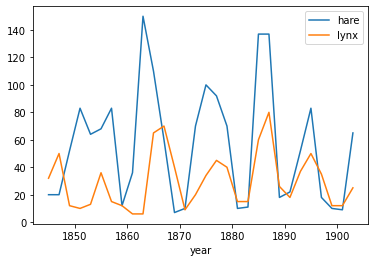

In [3]:
df.plot()

#### Interpolate

In [4]:
def densify(t,y,dt):
    
    f = interp1d(t, y, kind='cubic')
    
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return tnew, ynew

In [5]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

In [6]:
dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

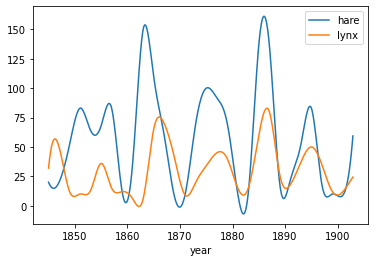

In [7]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

In [8]:
x = np.vstack([x1,x2])
x = x.T
x.shape

(580, 2)

#### Prepare inputs for DMD

In [9]:
r   = 2
X1  = x[:-1].T
X2  = x[1:].T

#### Define DMD function 

In [10]:
def DMD(X,Xprime,r):
    
    # Step 1 take SVD and rank truncate
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2 compute Atide with decomposed matrix
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3 eigenvalue decomposition to get subspace eigenvectors W and eigenvalues Lambda 
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4 project back into high dimensional space
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

#### Run DMD and forecast

In [11]:
Phi, Lambda, b = DMD(X1,X2,r)

In [12]:
omega = np.log(np.diag(Lambda))/dt

In [13]:
forecast = []

for i in np.arange(0,58,dt):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

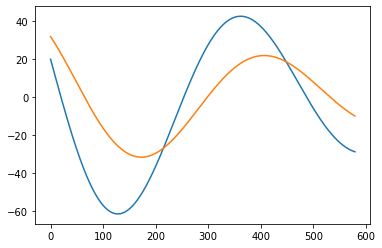

In [14]:
plt.plot(forecast);

#### Compare with original data

In [15]:
df_new['hare_prediction']  = forecast[:,0]
df_new['lynx_prediction']  = forecast[:,1]

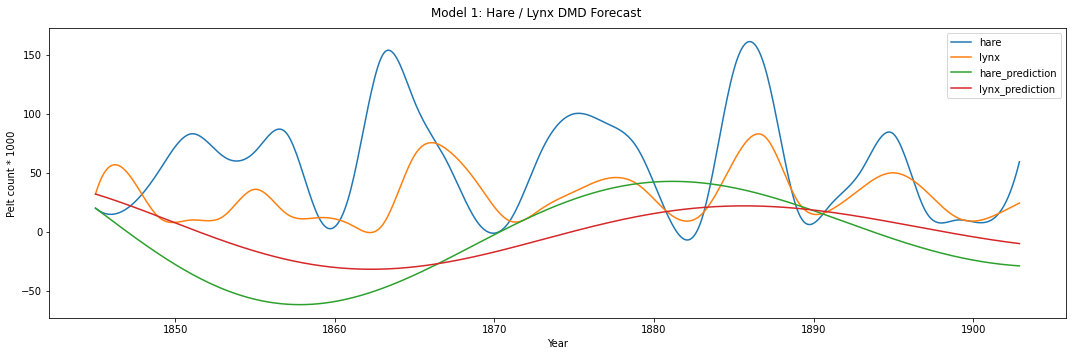

In [16]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Model 1: Hare / Lynx DMD Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('plots/Q1_fig1.png')

#### Save model result

In [17]:
models = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
models['hare_prediction_DMD']  = forecast[:,0]
models['lynx_prediction_DMD']  = forecast[:,1]

### 2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

#### Prepare interpolated data

In [18]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

In [19]:
dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)
x = np.vstack([x1,x2])
x = x.T
x.shape

(580, 2)

#### Create Hankel matrix

In [20]:
from scipy.linalg import hankel
H = hankel(x)

In [21]:
H.shape

(1160, 1160)

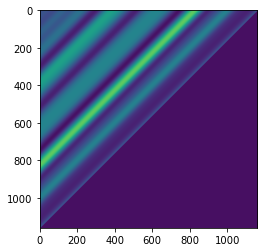

In [22]:
plt.imshow(H);

### Examine variance explained by each mode

In [23]:
U,Sigma,VT = np.linalg.svd(H,full_matrices=0)
Sigma = Sigma[:60]
var_explained = np.diag(np.diag(Sigma)/np.sum(np.diag(Sigma)))

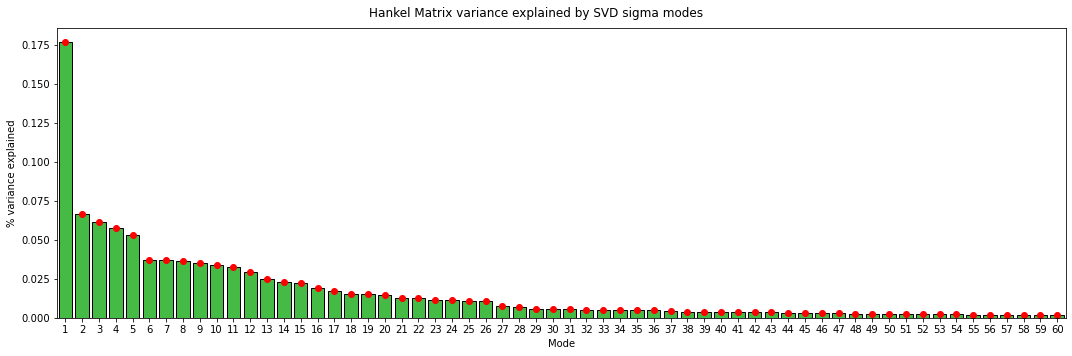

In [24]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1,1,1)
ax.plot(var_explained, 'ro');
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, 
            color="limegreen", 
            ec='k', 
            ax=ax)

plt.suptitle('Hankel Matrix variance explained by SVD sigma modes')
plt.xlabel('Mode')
plt.ylabel('% variance explained')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('plots/Q2_fig1.png')

#### Prepare inputs for DMD

In [25]:
X1 = H[:-1].T
X2 = H[1:].T

In [26]:
X2.shape

(1160, 1159)

#### Forecast

In [27]:
r = 30
Phi, Lambda, b = DMD(X1,X2,r)

In [28]:
Phi.shape, Lambda.shape, b.shape

((1160, 30), (30, 30), (30,))

In [29]:
omega = np.log(np.diag(Lambda))/dt

In [30]:
forecast = []

for i in np.arange(0,116,.1):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

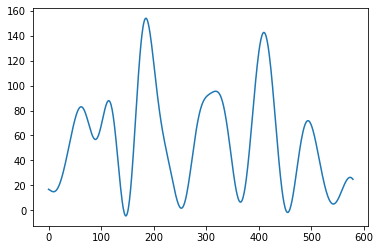

In [31]:
plt.plot(forecast.T[0][0::2]);

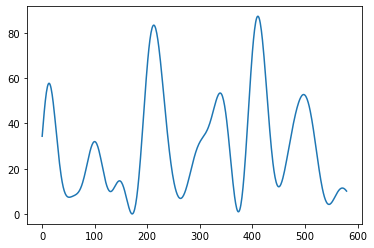

In [32]:
plt.plot(forecast.T[0][1::2]);

In [33]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new['hare_prediction']  = forecast.T[0][0::2]
df_new['lynx_prediction']  = forecast.T[0][1::2]

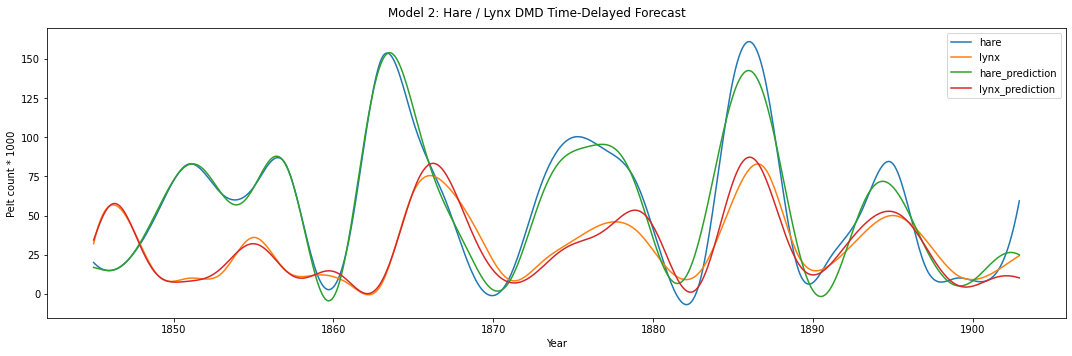

In [34]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Model 2: Hare / Lynx DMD Time-Delayed Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('plots/Q2_fig2.png')

#### Save model result

In [35]:
models['hare_prediction_DMD_TD']  = forecast.T[0][0::2]
models['lynx_prediction_DMD_TD']  = forecast.T[0][1::2]

### 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.

#### Define function

In [36]:
def lotkavolterra(t, x0, b, p, d, r):
    x, y = x0
    return [b*x - p*x*y, -d*y + r*x*y]

#### Interpolate time series

In [37]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.2
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

#### Plot initial dense data

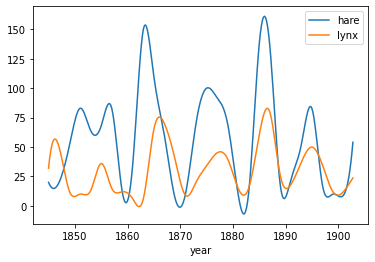

In [38]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

#### Set up SINDy to get initial guess

In [39]:
def SINDy(x1s, x2s, Ax1s, Ax2s, dt):
    # compute derivative
    n = len(t)
    x1dots = []
    x2dots = []
    for j in range(1,n-1):
        x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
        x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
        x1dots.append(x1dot)
        x2dots.append(x2dot)
    x1dots = np.array(x1dots)
    x2dots = np.array(x2dots)

    # run linear regression to find coefficients
    clf1 = linear_model.Lasso(alpha=0.001)
    clf1.fit(Ax1s.T, x1dots)
    clf2 = linear_model.Lasso(alpha=0.001)
    clf2.fit(Ax2s.T, x2dots)

    return clf1.coef_, clf2.coef_

#### Create matrix A from inner time series for each term

In [40]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s])
Ax2s = np.array([x2s, x1s*x2s])

In [41]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, 
                 x1s*x2s])
                
Ax2s = np.array([x2s, 
                 x1s*x2s])

#### Run SINDy

In [42]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

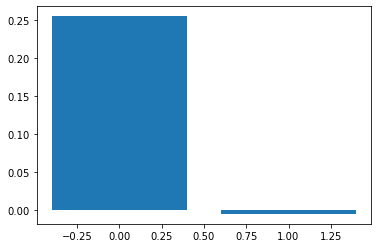

In [43]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

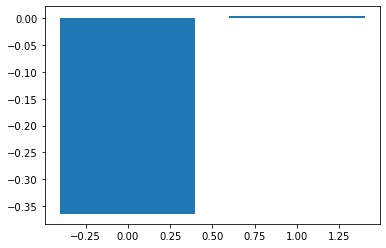

In [44]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out coefficients

In [45]:
b, p, d, r = np.abs((clf1_coef[0], clf1_coef[1], clf2_coef[0], clf2_coef[1]))
b, p, d, r

(0.25537416681302194,
 0.005496395045871686,
 0.36435281521610596,
 0.003433344270585564)

#### Make prediction

In [46]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

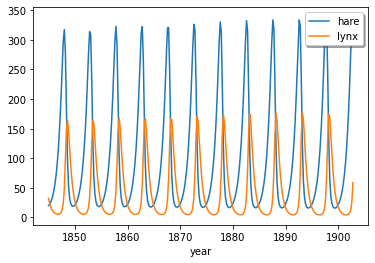

In [47]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

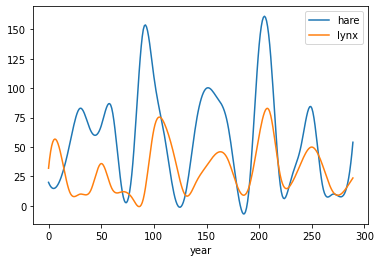

In [48]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

#### Best approximation after trial and error

In [49]:
b, p, d, r = 0.14, 0.005, 0.2, 0.0034 # best approximation after trial and error
b, p, d, r

(0.14, 0.005, 0.2, 0.0034)

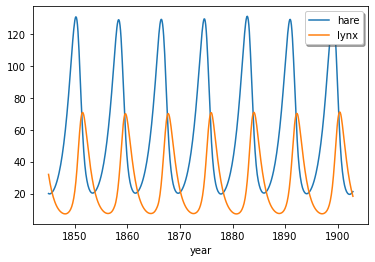

In [50]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

t = np.arange(0, len(t), 0.5)
pred_estimated = sol.sol(t)

x = np.arange(years[0], years[-1], 0.1)
plt.plot(x, pred_estimated.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare to original

In [51]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

In [52]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new['hare_prediction']  = pred_estimated[0]
df_new['lynx_prediction']  = pred_estimated[1]

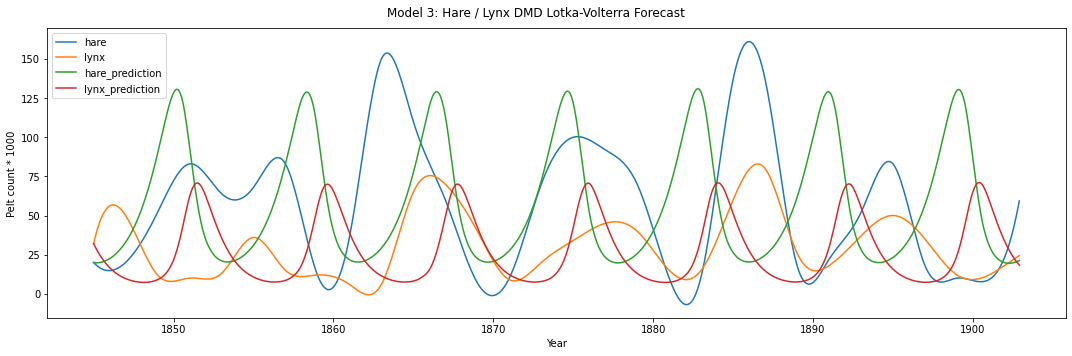

In [53]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Model 3: Hare / Lynx DMD Lotka-Volterra Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('plots/Q3_fig1.png')

#### Save model result

In [54]:
models['hare_prediction_LV']  = pred_estimated[0]
models['lynx_prediction_LV']  = pred_estimated[1]

### 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

#### Initial guess at a possible model

In [55]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.2
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

In [56]:
def lotkavolterra_nonlin(t, x0, a, b):
    x, y = x0
    return [a*np.sin(t*.1), b*np.cos(t*.1)]

In [57]:
a = 4
b = -2

In [58]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra_nonlin, t_range, x0, args=(a,b), dense_output=True)

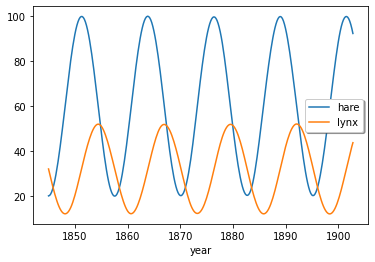

In [59]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show();

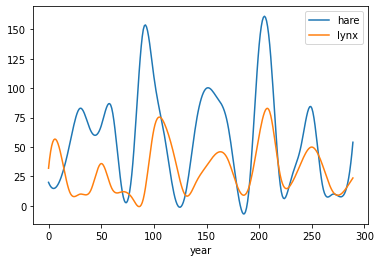

In [60]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

#### Create matrix A with non linear terms

In [61]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s, np.cos(x1s), np.sin(x1s), np.cos(x2s), np.sin(x2s)])
Ax2s = np.array([x2s, x1s*x2s, np.cos(x2s), np.sin(x2s), np.cos(x1s), np.sin(x1s)])

#### Run SINDy

In [62]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

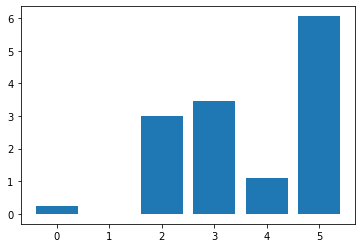

In [63]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

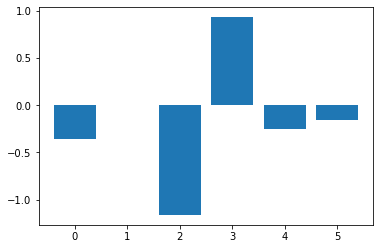

In [64]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out terms that fit simple nonlinear model proposed above

In [65]:
a = np.abs(clf1_coef[3])
b = np.abs(clf2_coef[2])

#### Make prediction

In [66]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra_nonlin, t_range, x0, args=(a,b), dense_output=True)

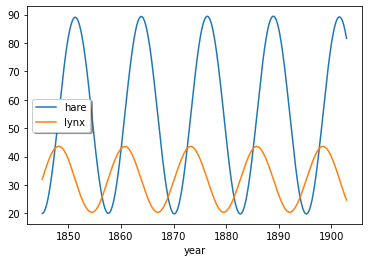

In [67]:
t = np.arange(0, len(t), 0.5)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], 0.1)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

In [68]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

In [69]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])

In [70]:
df_new['hare_prediction']  = pred_sindy_derived[0]
df_new['lynx_prediction']  = pred_sindy_derived[1]

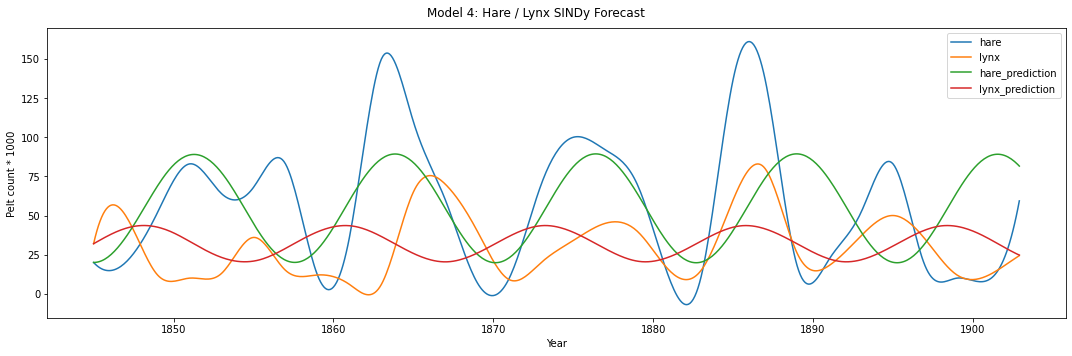

In [71]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
df_new.plot(ax=ax)
plt.suptitle('Model 4: Hare / Lynx SINDy Forecast')
plt.xlabel('Year')
plt.ylabel('Pelt count * 1000')
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('plots/Q4_fig1.png')

#### Save model result

In [72]:
models['hare_prediction_SINDy']  = pred_sindy_derived[0]
models['lynx_prediction_SINDy']  = pred_sindy_derived[1]

### 5. Compute the KL divergence of the best model fit to the data between all the above models.

In [73]:
models.head()

,hare,lynx,hare_prediction_DMD,lynx_prediction_DMD,hare_prediction_DMD_TD,lynx_prediction_DMD_TD,hare_prediction_LV,lynx_prediction_LV,hare_prediction_SINDy,lynx_prediction_SINDy
year,,,,,,,,,,
1845.0,20.000000,32.000000,20.000000+0.000000j,32.000000+0.000000j,16.850750-0.000000j,34.332474+0.000000j,20.000000,32.000000,20.000000,32.000000
1845.1,18.943997,36.245300,18.982937+0.000000j,31.583546-0.000000j,16.608470+0.000000j,37.174778+0.000000j,19.852273,29.951998,20.043248,32.580825
1845.2,18.013534,40.040554,17.965593+0.000000j,31.162621+0.000000j,16.338598+0.000000j,39.983281+0.000000j,19.803660,28.030404,20.172882,33.160199
1845.3,17.206212,43.402079,16.948155+0.000000j,30.737314+0.000000j,16.056380+0.000000j,42.708176+0.000000j,19.847229,26.232003,20.388579,33.736672
1845.4,16.519636,46.346195,15.930808+0.000000j,30.307718+0.000000j,15.776542+0.000000j,45.303736+0.000000j,19.976938,24.552979,20.689800,34.308805


In [74]:
# adapted from https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7
def kl(truth, prediction):
    z = truth * np.log(truth / prediction)
    z[np.isnan(z)] = 0
    return np.sum(z)

### Hare model KL divergence

In [75]:
hare = models.hare.values
model_1_hare_prediction = models.hare_prediction_DMD.values.real
model_2_hare_prediction = models.hare_prediction_DMD_TD.values.real
model_3_hare_prediction = models.hare_prediction_LV.values
model_4_hare_prediction = models.hare_prediction_SINDy.values

In [76]:
kl(hare, model_1_hare_prediction)

17658.35171167864

In [77]:
kl(hare, model_2_hare_prediction)

1026.2717868900638

In [78]:
kl(hare, model_3_hare_prediction)

18559.004970045793

In [79]:
kl(hare, model_4_hare_prediction)

9581.582036797994

### Lynx model divergence

In [80]:
lynx = models.lynx.values
model_1_lynx_prediction = models.lynx_prediction_DMD.values.real
model_2_lynx_prediction = models.lynx_prediction_DMD_TD.values.real
model_3_lynx_prediction = models.lynx_prediction_LV.values
model_4_lynx_prediction = models.lynx_prediction_SINDy.values

In [81]:
kl(lynx, model_1_lynx_prediction)

12814.299433223017

In [82]:
kl(lynx, model_2_lynx_prediction)

579.9684018793332

In [83]:
kl(lynx, model_3_lynx_prediction)

10708.860846763837

In [84]:
kl(lynx, model_4_lynx_prediction)

3703.0150757760534

### 6. Retain three of your best fit models and compare their AIC and BIC scores.

In [85]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

### Hare model AIC/BIC

In [86]:
regr = OLS(model_1_hare_prediction, add_constant(hare)).fit()
print(regr.bic)
print(regr.aic)

5742.285209615673
5733.5591534085925


In [87]:
regr = OLS(model_2_hare_prediction, add_constant(hare)).fit()
print(regr.bic)
print(regr.aic)

4069.1996105164626
4060.4735543093816


In [88]:
regr = OLS(model_3_hare_prediction, add_constant(hare)).fit()
print(regr.bic)
print(regr.aic)

5833.743085190862
5825.0170289837815


In [89]:
regr = OLS(model_4_hare_prediction, add_constant(hare)).fit()
print(regr.bic)
print(regr.aic)

5295.568101119448
5286.842044912368


### Lynx model AIC/BIC

In [90]:
regr = OLS(model_1_lynx_prediction, add_constant(lynx)).fit()
print(regr.bic)
print(regr.aic)

5010.309019495503
5001.582963288422


In [91]:
regr = OLS(model_2_lynx_prediction, add_constant(lynx)).fit()
print(regr.bic)
print(regr.aic)

3531.677397367944
3522.951341160863


In [92]:
regr = OLS(model_3_lynx_prediction, add_constant(lynx)).fit()
print(regr.bic)
print(regr.aic)

5190.793784336227
5182.067728129146


In [93]:
regr = OLS(model_4_lynx_prediction, add_constant(lynx)).fit()
print(regr.bic)
print(regr.aic)

4058.8548073813836
4050.1287511743026


#### Explicait AIC/BIC computation

In [94]:
def compute_AICBIC(truth, 
                   predictions, 
                   number_of_terms, 
                   observation_count):
    
    residuals = truth - predictions
    sse = sum(residuals**2)
    aic = 2*number_of_terms - 2 * np.log(sse)
    bic = np.log(observation_count) * number_of_terms - 2 * np.log(sse)
    
    return aic, bic

#### Hare

In [95]:
compute_AICBIC(hare, model_1_hare_prediction, 2, 580)

(-26.40535160096019, -17.67929539387926)

In [96]:
compute_AICBIC(hare, model_2_hare_prediction, 2, 580)

(-17.255216401618256, -8.529160194537326)

In [97]:
compute_AICBIC(hare, model_3_hare_prediction, 4, 580)

(-21.180753976679664, -3.7286415625178044)

In [98]:
compute_AICBIC(hare, model_4_hare_prediction, 2, 580)

(-23.478347468477782, -14.752291261396852)

#### Lynx

In [99]:
compute_AICBIC(lynx, model_1_lynx_prediction, 2, 580)

(-23.434818070127097, -14.708761863046167)

In [100]:
compute_AICBIC(lynx, model_2_lynx_prediction, 2, 580)

(-15.328718776478727, -6.602662569397797)

In [101]:
compute_AICBIC(lynx, model_3_lynx_prediction, 4, 580)

(-18.310519418949575, -0.8584070047877148)

In [102]:
compute_AICBIC(lynx, model_4_lynx_prediction, 2, 580)

(-21.29497379795875, -12.56891759087782)

### Download the data set BZ.mat (which is a snipet from a Belousov-Zhabotinsky chemical oscillator movie – check them out on youtube).


#### 1. get the data: download from the course website (It is next to HW 2)
#### 2. See what you can do with the data (i.e. repeat the first two steps above)   

In [103]:
import h5py
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

#### Import data

In [104]:
f = h5py.File('./data/BZ.mat','r')
data = f.get('BZ_tensor')
data = np.array(data)

#### First image

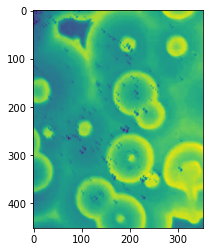

In [105]:
plt.imshow(data[0])

In [106]:
data.shape

(1200, 451, 351)

#### Save as video

In [107]:
# fig = plt.figure()
# ims = []
# for i in data:
#     im = plt.imshow(i, animated=True)
#     ims.append([im])
# ani = animation.ArtistAnimation(fig, ims)
# ani.save('plots/movie_full.mp4')

#### Subset window for analysis and save first 300 frames

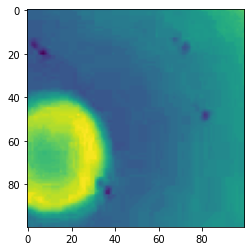

In [108]:
plt.imshow(data[0][100:200,0:100])

In [109]:
print('Frames:', len(data))
print('Movie duration: 4:00 min')
print('Frames per minute:', 300)

Frames: 1200
Movie duration: 4:00 min
Frames per minute: 300


In [110]:
fig = plt.figure()
ims = []
for i in range(300):
    im = plt.imshow(data[i][100:200,0:100], animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims)
plt.close(ani._fig)
HTML(ani.to_html5_video())
# ani.save('plots/movie_sub.mp4')

#### Prepare subsetted data for analysis

In [111]:
data_sub = []
for i in range(300):
    frame = data[i][120:180,20:80]
    data_sub.append(frame)
data_sub = np.array(data_sub)

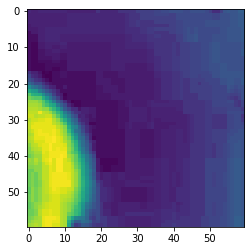

In [112]:
plt.imshow(data_sub[0]);

In [113]:
data.shape

(1200, 451, 351)

In [114]:
data_sub.shape

(300, 60, 60)

#### Flatten image arrays

In [115]:
X = []
for i in data_sub:
    X.append(i.flatten())
    
X = np.array(X)

In [116]:
X.shape

(300, 3600)

#### Prepare data for DMD

In [117]:
r = 10
X1 = X[0:-1].T
X2 = X[1:].T

#### Run DMD and forecast

In [118]:
Phi, Lambda, b = DMD(X1,X2,r)

In [119]:
omega = np.log(np.diag(Lambda))/dt

In [120]:
forecast = []

for i in np.arange(0,200,dt):
    c = Phi @ np.diag(np.exp(omega*i)) @ b.T
    forecast.append(c.flatten())
forecast = np.array(forecast)

#### Compare first image array to forecast

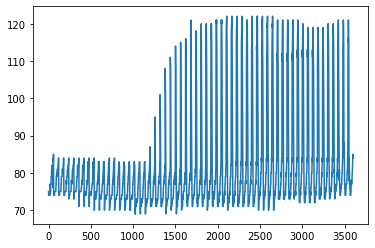

In [121]:
plt.plot(X1.T[0])

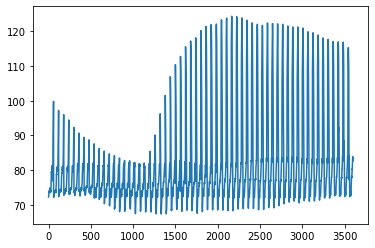

In [122]:
plt.plot(forecast[0])

#### Reconstruct the predicted data and save as video

In [123]:
reconstructed_data = []

for i in range(len(forecast)):
    im = forecast[i].real.reshape(60,60)
    reconstructed_data.append(im)

reconstructed_data = np.array(reconstructed_data)

In [ ]:
fig = plt.figure()
ims = []
for i in reconstructed_data:
    im = plt.imshow(i, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims)
plt.close(ani._fig)
HTML(ani.to_html5_video())
# ani.save('plots/movie_sub_reconstructed_60.mp4')

#### Compare with original

In [ ]:
plt.imshow(data_sub[0])

In [ ]:
plt.imshow(reconstructed_data[0])

#### Save frames

In [ ]:
plt.imshow(data_sub[0])
plt.tight_layout()
plt.savefig('plots/Q7_frame1_original.png')

plt.imshow(data_sub[100])
plt.tight_layout()
plt.savefig('plots/Q7_frame100_original.png')

plt.imshow(data_sub[200])
plt.tight_layout()
plt.savefig('plots/Q7_frame200_original.png')

plt.imshow(data_sub[300-1])
plt.tight_layout()
plt.savefig('plots/Q7_frame300_original.png')

In [ ]:
plt.imshow(reconstructed_data[0])
plt.tight_layout()
plt.savefig('plots/Q7_frame1_reconstructed.png')

plt.imshow(reconstructed_data[100])
plt.tight_layout()
plt.savefig('plots/Q7_frame100_reconstructed.png')

plt.imshow(reconstructed_data[200])
plt.tight_layout()
plt.savefig('plots/Q7_frame200_reconstructed.png')

plt.imshow(reconstructed_data[300-1])
plt.tight_layout()
plt.savefig('plots/Q7_frame300_reconstructed.png')